In [1]:
# import packages
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Variables
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_0_layer.pth'

/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [3]:
# Only extract hidden states
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        hidden_states.append(outputs.hidden_states[17].mean(dim=1).cpu().numpy())
    return np.vstack(hidden_states)

In [4]:
# lode data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement

In [5]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2000, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_f1 = -float('inf')  # Track best F1-score
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # Every 10 epochs, evaluate the model
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            # Calculate accuracy and F1-score
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)  # F1-score calculation
            
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            print(f"Test F1-score at Epoch {epoch + 1}: {f1:.4f}")
            
            # Generate classification report
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            # Save the model if it achieves a better F1-score
            if f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with F1-score {best_f1:.4f} at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    # Load the best model state
    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    print(f"Final Model F1-score: {best_f1:.4f}")
    
    return custom_mlp, losses, best_accuracy, best_f1


In [6]:

tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement = load_data(non_infringement_file, infringement_file)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]


In [7]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 232/232 [01:02<00:00,  3.71it/s]


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 243/243 [01:20<00:00,  3.02it/s]


In [8]:
split_index_non_infringement = int(0.8 * len(X_non_infringement))
X_non_infringement_train = X_non_infringement[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement))
X_infringement_train = X_infringement[:split_index_infringement]
X_infringement_test = X_infringement[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training MLP model with input_dim=4096 and hidden_dim=256


Training Epochs:   1%|          | 16/2000 [00:00<00:58, 33.76it/s]

Epoch 10/2000, Loss: 0.4825
Test Accuracy at Epoch 10: 67.63%
Test F1-score at Epoch 10: 0.7064
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.74      0.56      0.64       194
non_infringement       0.64      0.80      0.71       186

        accuracy                           0.68       380
       macro avg       0.69      0.68      0.67       380
    weighted avg       0.69      0.68      0.67       380

New best model saved with F1-score 0.7064 at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.74      0.56      0.64       194
non_infringement       0.64      0.80      0.71       186

        accuracy                           0.68       380
       macro avg       0.69      0.68      0.67       380
    weighted avg       0.69      0.68      0.67       380



Training Epochs:   1%|          | 24/2000 [00:00<00:59, 32.98it/s]

Epoch 20/2000, Loss: 0.3638
Test Accuracy at Epoch 20: 71.32%
Test F1-score at Epoch 20: 0.7295
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.76      0.64      0.69       194
non_infringement       0.68      0.79      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380

New best model saved with F1-score 0.7295 at epoch 20
Best Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.76      0.64      0.69       194
non_infringement       0.68      0.79      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:   2%|▏         | 33/2000 [00:01<00:57, 34.49it/s]

Epoch 30/2000, Loss: 0.3251
Test Accuracy at Epoch 30: 71.32%
Test F1-score at Epoch 30: 0.7309
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.76      0.63      0.69       194
non_infringement       0.68      0.80      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380

New best model saved with F1-score 0.7309 at epoch 30
Best Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.76      0.63      0.69       194
non_infringement       0.68      0.80      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:   2%|▏         | 46/2000 [00:01<00:54, 35.90it/s]

Epoch 40/2000, Loss: 0.2903
Test Accuracy at Epoch 40: 70.26%
Test F1-score at Epoch 40: 0.7196
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.75      0.63      0.68       194
non_infringement       0.67      0.78      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:   3%|▎         | 55/2000 [00:01<00:55, 34.81it/s]

Epoch 50/2000, Loss: 0.2619
Test Accuracy at Epoch 50: 70.26%
Test F1-score at Epoch 50: 0.7050
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.72      0.68      0.70       194
non_infringement       0.69      0.73      0.70       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380



Training Epochs:   3%|▎         | 64/2000 [00:01<00:58, 33.29it/s]

Epoch 60/2000, Loss: 0.2186
Test Accuracy at Epoch 60: 68.16%
Test F1-score at Epoch 60: 0.7042
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.73      0.59      0.66       194
non_infringement       0.65      0.77      0.70       186

        accuracy                           0.68       380
       macro avg       0.69      0.68      0.68       380
    weighted avg       0.69      0.68      0.68       380



Training Epochs:   3%|▎         | 68/2000 [00:02<00:56, 34.14it/s]

Epoch 70/2000, Loss: 0.1909
Test Accuracy at Epoch 70: 71.84%
Test F1-score at Epoch 70: 0.7263
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.75      0.68      0.71       194
non_infringement       0.69      0.76      0.73       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.72       380
    weighted avg       0.72      0.72      0.72       380



Training Epochs:   4%|▍         | 84/2000 [00:02<01:08, 27.92it/s]

Epoch 80/2000, Loss: 0.1680
Test Accuracy at Epoch 80: 70.79%
Test F1-score at Epoch 80: 0.7132
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.73      0.68      0.70       194
non_infringement       0.69      0.74      0.71       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380



Training Epochs:   5%|▍         | 93/2000 [00:02<00:55, 34.41it/s]

Epoch 90/2000, Loss: 0.1539
Test Accuracy at Epoch 90: 72.11%
Test F1-score at Epoch 90: 0.7225
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.74      0.70      0.72       194
non_infringement       0.70      0.74      0.72       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.72       380
    weighted avg       0.72      0.72      0.72       380



Training Epochs:   5%|▌         | 103/2000 [00:03<00:53, 35.21it/s]

Epoch 100/2000, Loss: 0.1446
Test Accuracy at Epoch 100: 73.42%
Test F1-score at Epoch 100: 0.7390
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.76      0.70      0.73       194
non_infringement       0.71      0.77      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380

New best model saved with F1-score 0.7390 at epoch 100
Best Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.76      0.70      0.73       194
non_infringement       0.71      0.77      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:   6%|▌         | 117/2000 [00:03<00:53, 35.07it/s]

Epoch 110/2000, Loss: 0.1373
Test Accuracy at Epoch 110: 72.11%
Test F1-score at Epoch 110: 0.7310
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.76      0.67      0.71       194
non_infringement       0.69      0.77      0.73       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.72       380
    weighted avg       0.72      0.72      0.72       380



Training Epochs:   6%|▋         | 127/2000 [00:03<00:50, 37.35it/s]

Epoch 120/2000, Loss: 0.1309
Test Accuracy at Epoch 120: 72.11%
Test F1-score at Epoch 120: 0.7310
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.76      0.67      0.71       194
non_infringement       0.69      0.77      0.73       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.72       380
    weighted avg       0.72      0.72      0.72       380



Training Epochs:   7%|▋         | 137/2000 [00:04<00:45, 41.01it/s]

Epoch 130/2000, Loss: 0.1274
Test Accuracy at Epoch 130: 73.42%
Test F1-score at Epoch 130: 0.7390
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.76      0.70      0.73       194
non_infringement       0.71      0.77      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:   7%|▋         | 142/2000 [00:04<00:51, 36.04it/s]

Epoch 140/2000, Loss: 0.1224
Test Accuracy at Epoch 140: 70.00%
Test F1-score at Epoch 140: 0.7150
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.74      0.63      0.68       194
non_infringement       0.67      0.77      0.71       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:   8%|▊         | 159/2000 [00:04<00:39, 46.87it/s]

Epoch 150/2000, Loss: 0.1227
Test Accuracy at Epoch 150: 73.16%
Test F1-score at Epoch 150: 0.7330
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.75      0.71      0.73       194
non_infringement       0.71      0.75      0.73       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:   8%|▊         | 164/2000 [00:04<00:43, 41.76it/s]

Epoch 160/2000, Loss: 0.1294
Test Accuracy at Epoch 160: 73.16%
Test F1-score at Epoch 160: 0.7330
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.75      0.71      0.73       194
non_infringement       0.71      0.75      0.73       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380

Epoch 170/2000, Loss: 0.1186
Test Accuracy at Epoch 170: 69.74%
Test F1-score at Epoch 170: 0.7132


Training Epochs:   9%|▉         | 177/2000 [00:05<00:37, 48.78it/s]

Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.74      0.63      0.68       194
non_infringement       0.67      0.77      0.71       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380



Training Epochs:   9%|▉         | 189/2000 [00:05<00:39, 45.42it/s]

Epoch 180/2000, Loss: 0.1151
Test Accuracy at Epoch 180: 72.11%
Test F1-score at Epoch 180: 0.7296
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.75      0.68      0.71       194
non_infringement       0.69      0.77      0.73       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.72       380
    weighted avg       0.72      0.72      0.72       380



Training Epochs:  10%|▉         | 194/2000 [00:05<00:39, 45.68it/s]

Epoch 190/2000, Loss: 0.1123
Test Accuracy at Epoch 190: 70.26%
Test F1-score at Epoch 190: 0.7168
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.69       194
non_infringement       0.67      0.77      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  10%|█         | 210/2000 [00:05<00:39, 45.89it/s]

Epoch 200/2000, Loss: 0.1113
Test Accuracy at Epoch 200: 71.84%
Test F1-score at Epoch 200: 0.7277
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.75      0.67      0.71       194
non_infringement       0.69      0.77      0.73       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.72       380
    weighted avg       0.72      0.72      0.72       380

Epoch 210/2000, Loss: 0.1099
Test Accuracy at Epoch 210: 71.84%
Test F1-score at Epoch 210: 0.7277
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.75      0.67      0.71       194
non_infringement       0.69      0.77      0.73       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.72       380
    weighted avg       0.72      0.72      0.72       380



Training Epochs:  11%|█▏        | 227/2000 [00:06<00:37, 47.24it/s]

Epoch 220/2000, Loss: 0.1088
Test Accuracy at Epoch 220: 72.11%
Test F1-score at Epoch 220: 0.7296
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.75      0.68      0.71       194
non_infringement       0.69      0.77      0.73       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.72       380
    weighted avg       0.72      0.72      0.72       380

Epoch 230/2000, Loss: 0.1080


Training Epochs:  12%|█▏        | 239/2000 [00:06<00:35, 49.04it/s]

Test Accuracy at Epoch 230: 72.11%
Test F1-score at Epoch 230: 0.7296
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.75      0.68      0.71       194
non_infringement       0.69      0.77      0.73       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.72       380
    weighted avg       0.72      0.72      0.72       380



Training Epochs:  12%|█▏        | 245/2000 [00:06<00:35, 49.83it/s]

Epoch 240/2000, Loss: 0.1155
Test Accuracy at Epoch 240: 69.21%
Test F1-score at Epoch 240: 0.7153
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.75      0.60      0.66       194
non_infringement       0.65      0.79      0.72       186

        accuracy                           0.69       380
       macro avg       0.70      0.69      0.69       380
    weighted avg       0.70      0.69      0.69       380

Epoch 250/2000, Loss: 0.1131


Training Epochs:  13%|█▎        | 257/2000 [00:06<00:38, 44.74it/s]

Test Accuracy at Epoch 250: 74.74%
Test F1-score at Epoch 250: 0.7526
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.78      0.71      0.74       194
non_infringement       0.72      0.78      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380

New best model saved with F1-score 0.7526 at epoch 250
Best Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.78      0.71      0.74       194
non_infringement       0.72      0.78      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  13%|█▎        | 267/2000 [00:07<00:40, 42.84it/s]

Epoch 260/2000, Loss: 0.1112
Test Accuracy at Epoch 260: 74.21%
Test F1-score at Epoch 260: 0.7448
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.76      0.72      0.74       194
non_infringement       0.72      0.77      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  14%|█▍        | 279/2000 [00:07<00:35, 48.22it/s]

Epoch 270/2000, Loss: 0.1076
Test Accuracy at Epoch 270: 72.37%
Test F1-score at Epoch 270: 0.7355
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.76      0.66      0.71       194
non_infringement       0.69      0.78      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380

Epoch 280/2000, Loss: 0.1059
Test Accuracy at Epoch 280: 73.16%
Test F1-score at Epoch 280: 0.7411


Training Epochs:  14%|█▍        | 284/2000 [00:07<00:35, 48.07it/s]

Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.78      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  15%|█▍        | 294/2000 [00:07<00:38, 44.59it/s]

Epoch 290/2000, Loss: 0.1049
Test Accuracy at Epoch 290: 72.63%
Test F1-score at Epoch 290: 0.7374
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.76      0.67      0.71       194
non_infringement       0.70      0.78      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380

Epoch 300/2000, Loss: 0.1043


Training Epochs:  15%|█▌        | 305/2000 [00:07<00:39, 42.78it/s]

Test Accuracy at Epoch 300: 72.63%
Test F1-score at Epoch 300: 0.7374
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.76      0.67      0.71       194
non_infringement       0.70      0.78      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  16%|█▌        | 316/2000 [00:08<00:35, 47.89it/s]

Epoch 310/2000, Loss: 0.1038
Test Accuracy at Epoch 310: 73.16%
Test F1-score at Epoch 310: 0.7411
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.78      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380

Epoch 320/2000, Loss: 0.1034
Test Accuracy at Epoch 320: 73.16%
Test F1-score at Epoch 320: 0.7411


Training Epochs:  16%|█▋        | 327/2000 [00:08<00:36, 45.84it/s]

Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.78      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  17%|█▋        | 339/2000 [00:08<00:31, 52.73it/s]

Epoch 330/2000, Loss: 0.1029
Test Accuracy at Epoch 330: 72.89%
Test F1-score at Epoch 330: 0.7379
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.76      0.68      0.72       194
non_infringement       0.70      0.78      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380

Epoch 340/2000, Loss: 0.1035
Test Accuracy at Epoch 340: 74.74%
Test F1-score at Epoch 340: 0.7513
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.77      0.72      0.74       194
non_infringement       0.72      0.78      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  18%|█▊        | 356/2000 [00:08<00:34, 47.33it/s]

Epoch 350/2000, Loss: 0.1218
Test Accuracy at Epoch 350: 69.47%
Test F1-score at Epoch 350: 0.7171
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.75      0.60      0.67       194
non_infringement       0.66      0.79      0.72       186

        accuracy                           0.69       380
       macro avg       0.70      0.70      0.69       380
    weighted avg       0.70      0.69      0.69       380



Training Epochs:  18%|█▊        | 367/2000 [00:09<00:37, 43.68it/s]

Epoch 360/2000, Loss: 0.1053
Test Accuracy at Epoch 360: 76.32%
Test F1-score at Epoch 360: 0.7632
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.78      0.75      0.76       194
non_infringement       0.75      0.78      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380

New best model saved with F1-score 0.7632 at epoch 360
Best Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.78      0.75      0.76       194
non_infringement       0.75      0.78      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  19%|█▊        | 372/2000 [00:09<00:37, 43.91it/s]

Epoch 370/2000, Loss: 0.1048
Test Accuracy at Epoch 370: 72.89%
Test F1-score at Epoch 370: 0.7379
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.76      0.68      0.72       194
non_infringement       0.70      0.78      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  19%|█▉        | 387/2000 [00:09<00:37, 42.49it/s]

Epoch 380/2000, Loss: 0.1028
Test Accuracy at Epoch 380: 71.58%
Test F1-score at Epoch 380: 0.7313
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.76      0.64      0.70       194
non_infringement       0.68      0.79      0.73       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.71       380
    weighted avg       0.72      0.72      0.71       380



Training Epochs:  20%|█▉        | 392/2000 [00:09<00:43, 36.90it/s]

Epoch 390/2000, Loss: 0.1014
Test Accuracy at Epoch 390: 72.37%
Test F1-score at Epoch 390: 0.7355
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.76      0.66      0.71       194
non_infringement       0.69      0.78      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  20%|██        | 404/2000 [00:10<00:51, 30.77it/s]

Epoch 400/2000, Loss: 0.1012
Test Accuracy at Epoch 400: 72.37%
Test F1-score at Epoch 400: 0.7355
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.76      0.66      0.71       194
non_infringement       0.69      0.78      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  21%|██        | 413/2000 [00:10<00:45, 34.52it/s]

Epoch 410/2000, Loss: 0.1008
Test Accuracy at Epoch 410: 72.11%
Test F1-score at Epoch 410: 0.7337
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.76      0.66      0.71       194
non_infringement       0.69      0.78      0.73       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  21%|██▏       | 426/2000 [00:10<00:45, 34.71it/s]

Epoch 420/2000, Loss: 0.1005
Test Accuracy at Epoch 420: 72.11%
Test F1-score at Epoch 420: 0.7337
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.76      0.66      0.71       194
non_infringement       0.69      0.78      0.73       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  22%|██▏       | 434/2000 [00:11<00:49, 31.56it/s]

Epoch 430/2000, Loss: 0.1003
Test Accuracy at Epoch 430: 72.11%
Test F1-score at Epoch 430: 0.7350
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.77      0.65      0.71       194
non_infringement       0.69      0.79      0.73       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  22%|██▏       | 442/2000 [00:11<00:51, 30.05it/s]

Epoch 440/2000, Loss: 0.1000
Test Accuracy at Epoch 440: 72.37%
Test F1-score at Epoch 440: 0.7368
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.77      0.66      0.71       194
non_infringement       0.69      0.79      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  23%|██▎       | 456/2000 [00:11<00:43, 35.42it/s]

Epoch 450/2000, Loss: 0.0998
Test Accuracy at Epoch 450: 72.37%
Test F1-score at Epoch 450: 0.7368
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.77      0.66      0.71       194
non_infringement       0.69      0.79      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  23%|██▎       | 465/2000 [00:12<00:39, 38.74it/s]

Epoch 460/2000, Loss: 0.1004
Test Accuracy at Epoch 460: 74.74%
Test F1-score at Epoch 460: 0.7538
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.78      0.71      0.74       194
non_infringement       0.72      0.79      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  24%|██▎       | 474/2000 [00:12<00:40, 37.36it/s]

Epoch 470/2000, Loss: 0.1214
Test Accuracy at Epoch 470: 70.26%
Test F1-score at Epoch 470: 0.7251
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.76      0.61      0.68       194
non_infringement       0.66      0.80      0.73       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  24%|██▍       | 484/2000 [00:12<00:38, 39.43it/s]

Epoch 480/2000, Loss: 0.1049
Test Accuracy at Epoch 480: 77.11%
Test F1-score at Epoch 480: 0.7704
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.79      0.76      0.77       194
non_infringement       0.76      0.78      0.77       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380

New best model saved with F1-score 0.7704 at epoch 480
Best Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.79      0.76      0.77       194
non_infringement       0.76      0.78      0.77       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  25%|██▍       | 499/2000 [00:12<00:34, 43.84it/s]

Epoch 490/2000, Loss: 0.1014
Test Accuracy at Epoch 490: 72.37%
Test F1-score at Epoch 490: 0.7368
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.77      0.66      0.71       194
non_infringement       0.69      0.79      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.73      0.72      0.72       380

Epoch 500/2000, Loss: 0.1007


Training Epochs:  25%|██▌       | 504/2000 [00:13<00:33, 44.80it/s]

Test Accuracy at Epoch 500: 72.37%
Test F1-score at Epoch 500: 0.7382
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.77      0.65      0.71       194
non_infringement       0.69      0.80      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  26%|██▌       | 515/2000 [00:13<00:32, 45.65it/s]

Epoch 510/2000, Loss: 0.0993
Test Accuracy at Epoch 510: 73.16%
Test F1-score at Epoch 510: 0.7437
Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.77      0.67      0.72       194
non_infringement       0.70      0.80      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380

Epoch 520/2000, Loss: 0.0990
Test Accuracy at Epoch 520: 72.89%
Test F1-score at Epoch 520: 0.7419
Classification Report at Epoch 520:
                  precision    recall  f1-score   support

    infringement       0.77      0.66      0.71       194
non_infringement       0.69      0.80      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  27%|██▋       | 537/2000 [00:13<00:30, 47.99it/s]

Epoch 530/2000, Loss: 0.0988
Test Accuracy at Epoch 530: 72.89%
Test F1-score at Epoch 530: 0.7419
Classification Report at Epoch 530:
                  precision    recall  f1-score   support

    infringement       0.77      0.66      0.71       194
non_infringement       0.69      0.80      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380

Epoch 540/2000, Loss: 0.0987
Test Accuracy at Epoch 540: 72.89%
Test F1-score at Epoch 540: 0.7419
Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.77      0.66      0.71       194
non_infringement       0.69      0.80      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  28%|██▊       | 560/2000 [00:14<00:28, 50.44it/s]

Epoch 550/2000, Loss: 0.0985
Test Accuracy at Epoch 550: 72.89%
Test F1-score at Epoch 550: 0.7419
Classification Report at Epoch 550:
                  precision    recall  f1-score   support

    infringement       0.77      0.66      0.71       194
non_infringement       0.69      0.80      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380

Epoch 560/2000, Loss: 0.0983
Test Accuracy at Epoch 560: 72.89%
Test F1-score at Epoch 560: 0.7419
Classification Report at Epoch 560:
                  precision    recall  f1-score   support

    infringement       0.77      0.66      0.71       194
non_infringement       0.69      0.80      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  29%|██▉       | 578/2000 [00:14<00:27, 51.90it/s]

Epoch 570/2000, Loss: 0.0982
Test Accuracy at Epoch 570: 73.16%
Test F1-score at Epoch 570: 0.7437
Classification Report at Epoch 570:
                  precision    recall  f1-score   support

    infringement       0.77      0.67      0.72       194
non_infringement       0.70      0.80      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380

Epoch 580/2000, Loss: 0.0981
Test Accuracy at Epoch 580: 72.89%
Test F1-score at Epoch 580: 0.7419
Classification Report at Epoch 580:
                  precision    recall  f1-score   support

    infringement       0.77      0.66      0.71       194
non_infringement       0.69      0.80      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  30%|██▉       | 596/2000 [00:14<00:28, 49.59it/s]

Epoch 590/2000, Loss: 0.0979
Test Accuracy at Epoch 590: 72.89%
Test F1-score at Epoch 590: 0.7419
Classification Report at Epoch 590:
                  precision    recall  f1-score   support

    infringement       0.77      0.66      0.71       194
non_infringement       0.69      0.80      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  30%|███       | 608/2000 [00:15<00:28, 48.13it/s]

Epoch 600/2000, Loss: 0.0979
Test Accuracy at Epoch 600: 72.37%
Test F1-score at Epoch 600: 0.7382
Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.77      0.65      0.71       194
non_infringement       0.69      0.80      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.73      0.72      0.72       380

Epoch 610/2000, Loss: 0.0991
Test Accuracy at Epoch 610: 75.26%
Test F1-score at Epoch 610: 0.7577


Training Epochs:  31%|███       | 614/2000 [00:15<00:28, 49.37it/s]

Classification Report at Epoch 610:
                  precision    recall  f1-score   support

    infringement       0.78      0.72      0.75       194
non_infringement       0.73      0.79      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  31%|███▏      | 626/2000 [00:15<00:29, 46.46it/s]

Epoch 620/2000, Loss: 0.1026
Test Accuracy at Epoch 620: 74.74%
Test F1-score at Epoch 620: 0.7526
Classification Report at Epoch 620:
                  precision    recall  f1-score   support

    infringement       0.78      0.71      0.74       194
non_infringement       0.72      0.78      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380

Epoch 630/2000, Loss: 0.1101


Training Epochs:  32%|███▏      | 636/2000 [00:15<00:32, 41.91it/s]

Test Accuracy at Epoch 630: 75.53%
Test F1-score at Epoch 630: 0.7597
Classification Report at Epoch 630:
                  precision    recall  f1-score   support

    infringement       0.78      0.72      0.75       194
non_infringement       0.73      0.79      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  32%|███▏      | 647/2000 [00:16<00:29, 46.21it/s]

Epoch 640/2000, Loss: 0.0985
Test Accuracy at Epoch 640: 72.63%
Test F1-score at Epoch 640: 0.7400
Classification Report at Epoch 640:
                  precision    recall  f1-score   support

    infringement       0.77      0.66      0.71       194
non_infringement       0.69      0.80      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380

Epoch 650/2000, Loss: 0.0982


Training Epochs:  33%|███▎      | 657/2000 [00:16<00:30, 43.87it/s]

Test Accuracy at Epoch 650: 73.16%
Test F1-score at Epoch 650: 0.7424
Classification Report at Epoch 650:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  33%|███▎      | 669/2000 [00:16<00:26, 49.99it/s]

Epoch 660/2000, Loss: 0.0978
Test Accuracy at Epoch 660: 73.16%
Test F1-score at Epoch 660: 0.7424
Classification Report at Epoch 660:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380

Epoch 670/2000, Loss: 0.0975
Test Accuracy at Epoch 670: 72.89%
Test F1-score at Epoch 670: 0.7406
Classification Report at Epoch 670:
                  precision    recall  f1-score   support

    infringement       0.77      0.67      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  34%|███▍      | 686/2000 [00:16<00:26, 49.24it/s]

Epoch 680/2000, Loss: 0.0974
Test Accuracy at Epoch 680: 73.16%
Test F1-score at Epoch 680: 0.7424
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380

Epoch 690/2000, Loss: 0.0973
Test Accuracy at Epoch 690: 73.42%
Test F1-score at Epoch 690: 0.7443
Classification Report at Epoch 690:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  35%|███▌      | 704/2000 [00:17<00:26, 49.01it/s]

Epoch 700/2000, Loss: 0.0972
Test Accuracy at Epoch 700: 73.42%
Test F1-score at Epoch 700: 0.7443
Classification Report at Epoch 700:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380

Epoch 710/2000, Loss: 0.0971
Test Accuracy at Epoch 710: 73.16%
Test F1-score at Epoch 710: 0.7424


Training Epochs:  36%|███▌      | 716/2000 [00:17<00:25, 49.82it/s]

Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380

Epoch 720/2000, Loss: 0.0970
Test Accuracy at Epoch 720: 73.42%
Test F1-score at Epoch 720: 0.7443
Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  37%|███▋      | 735/2000 [00:17<00:26, 48.03it/s]

Epoch 730/2000, Loss: 0.0969
Test Accuracy at Epoch 730: 73.16%
Test F1-score at Epoch 730: 0.7424
Classification Report at Epoch 730:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  37%|███▋      | 747/2000 [00:18<00:24, 50.52it/s]

Epoch 740/2000, Loss: 0.0968
Test Accuracy at Epoch 740: 73.16%
Test F1-score at Epoch 740: 0.7424
Classification Report at Epoch 740:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  38%|███▊      | 759/2000 [00:18<00:26, 46.85it/s]

Epoch 750/2000, Loss: 0.0968
Test Accuracy at Epoch 750: 73.16%
Test F1-score at Epoch 750: 0.7424
Classification Report at Epoch 750:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380

Epoch 760/2000, Loss: 0.0967


Training Epochs:  38%|███▊      | 764/2000 [00:18<00:26, 46.91it/s]

Test Accuracy at Epoch 760: 73.16%
Test F1-score at Epoch 760: 0.7424
Classification Report at Epoch 760:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  39%|███▊      | 774/2000 [00:18<00:28, 43.76it/s]

Epoch 770/2000, Loss: 0.0968
Test Accuracy at Epoch 770: 72.63%
Test F1-score at Epoch 770: 0.7387
Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       0.77      0.66      0.71       194
non_infringement       0.69      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  39%|███▉      | 785/2000 [00:19<00:29, 41.03it/s]

Epoch 780/2000, Loss: 0.0971
Test Accuracy at Epoch 780: 74.74%
Test F1-score at Epoch 780: 0.7500
Classification Report at Epoch 780:
                  precision    recall  f1-score   support

    infringement       0.77      0.72      0.74       194
non_infringement       0.73      0.77      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  40%|███▉      | 795/2000 [00:19<00:28, 42.36it/s]

Epoch 790/2000, Loss: 0.1022
Test Accuracy at Epoch 790: 73.42%
Test F1-score at Epoch 790: 0.7443
Classification Report at Epoch 790:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  40%|████      | 805/2000 [00:19<00:30, 39.03it/s]

Epoch 800/2000, Loss: 0.1098
Test Accuracy at Epoch 800: 75.26%
Test F1-score at Epoch 800: 0.7552
Classification Report at Epoch 800:
                  precision    recall  f1-score   support

    infringement       0.77      0.73      0.75       194
non_infringement       0.73      0.78      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  41%|████      | 815/2000 [00:19<00:32, 36.39it/s]

Epoch 810/2000, Loss: 0.0977
Test Accuracy at Epoch 810: 72.89%
Test F1-score at Epoch 810: 0.7406
Classification Report at Epoch 810:
                  precision    recall  f1-score   support

    infringement       0.77      0.67      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  41%|████▏     | 825/2000 [00:20<00:29, 40.29it/s]

Epoch 820/2000, Loss: 0.0975
Test Accuracy at Epoch 820: 73.16%
Test F1-score at Epoch 820: 0.7424
Classification Report at Epoch 820:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  42%|████▏     | 835/2000 [00:20<00:29, 39.71it/s]

Epoch 830/2000, Loss: 0.0969
Test Accuracy at Epoch 830: 73.16%
Test F1-score at Epoch 830: 0.7424
Classification Report at Epoch 830:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  42%|████▏     | 846/2000 [00:20<00:26, 44.18it/s]

Epoch 840/2000, Loss: 0.0965
Test Accuracy at Epoch 840: 72.89%
Test F1-score at Epoch 840: 0.7406
Classification Report at Epoch 840:
                  precision    recall  f1-score   support

    infringement       0.77      0.67      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  43%|████▎     | 856/2000 [00:20<00:28, 40.54it/s]

Epoch 850/2000, Loss: 0.0965
Test Accuracy at Epoch 850: 73.16%
Test F1-score at Epoch 850: 0.7424
Classification Report at Epoch 850:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  43%|████▎     | 866/2000 [00:21<00:30, 37.62it/s]

Epoch 860/2000, Loss: 0.0964
Test Accuracy at Epoch 860: 72.89%
Test F1-score at Epoch 860: 0.7406
Classification Report at Epoch 860:
                  precision    recall  f1-score   support

    infringement       0.77      0.67      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  44%|████▍     | 876/2000 [00:21<00:27, 41.46it/s]

Epoch 870/2000, Loss: 0.0963
Test Accuracy at Epoch 870: 73.16%
Test F1-score at Epoch 870: 0.7424
Classification Report at Epoch 870:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  44%|████▍     | 887/2000 [00:21<00:28, 38.66it/s]

Epoch 880/2000, Loss: 0.0963
Test Accuracy at Epoch 880: 73.42%
Test F1-score at Epoch 880: 0.7443
Classification Report at Epoch 880:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  45%|████▍     | 892/2000 [00:21<00:31, 34.94it/s]

Epoch 890/2000, Loss: 0.0962
Test Accuracy at Epoch 890: 73.16%
Test F1-score at Epoch 890: 0.7424
Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  45%|████▌     | 902/2000 [00:22<00:28, 39.06it/s]

Epoch 900/2000, Loss: 0.0961
Test Accuracy at Epoch 900: 73.16%
Test F1-score at Epoch 900: 0.7424
Classification Report at Epoch 900:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  46%|████▌     | 918/2000 [00:22<00:25, 42.20it/s]

Epoch 910/2000, Loss: 0.0961
Test Accuracy at Epoch 910: 73.16%
Test F1-score at Epoch 910: 0.7424
Classification Report at Epoch 910:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  46%|████▌     | 923/2000 [00:22<00:25, 42.72it/s]

Epoch 920/2000, Loss: 0.0960
Test Accuracy at Epoch 920: 73.16%
Test F1-score at Epoch 920: 0.7424
Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  47%|████▋     | 940/2000 [00:22<00:22, 46.44it/s]

Epoch 930/2000, Loss: 0.0960
Test Accuracy at Epoch 930: 73.16%
Test F1-score at Epoch 930: 0.7424
Classification Report at Epoch 930:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380

Epoch 940/2000, Loss: 0.0959
Test Accuracy at Epoch 940: 73.16%
Test F1-score at Epoch 940: 0.7424
Classification Report at Epoch 940:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  48%|████▊     | 956/2000 [00:23<00:21, 49.12it/s]

Epoch 950/2000, Loss: 0.0959
Test Accuracy at Epoch 950: 73.16%
Test F1-score at Epoch 950: 0.7424
Classification Report at Epoch 950:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380

Epoch 960/2000, Loss: 0.0958
Test Accuracy at Epoch 960: 73.42%
Test F1-score at Epoch 960: 0.7443
Classification Report at Epoch 960:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  49%|████▉     | 979/2000 [00:23<00:20, 49.82it/s]

Epoch 970/2000, Loss: 0.1114
Test Accuracy at Epoch 970: 74.74%
Test F1-score at Epoch 970: 0.7513
Classification Report at Epoch 970:
                  precision    recall  f1-score   support

    infringement       0.77      0.72      0.74       194
non_infringement       0.72      0.78      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380

Epoch 980/2000, Loss: 0.1049
Test Accuracy at Epoch 980: 73.68%
Test F1-score at Epoch 980: 0.7354
Classification Report at Epoch 980:
                  precision    recall  f1-score   support

    infringement       0.75      0.73      0.74       194
non_infringement       0.72      0.75      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  50%|████▉     | 997/2000 [00:24<00:19, 50.70it/s]

Epoch 990/2000, Loss: 0.1107
Test Accuracy at Epoch 990: 74.74%
Test F1-score at Epoch 990: 0.7500
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       0.77      0.72      0.74       194
non_infringement       0.73      0.77      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380

Epoch 1000/2000, Loss: 0.0990
Test Accuracy at Epoch 1000: 71.32%
Test F1-score at Epoch 1000: 0.7309
Classification Report at Epoch 1000:
                  precision    recall  f1-score   support

    infringement       0.76      0.63      0.69       194
non_infringement       0.68      0.80      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:  51%|█████     | 1015/2000 [00:24<00:19, 50.49it/s]

Epoch 1010/2000, Loss: 0.0980
Test Accuracy at Epoch 1010: 73.16%
Test F1-score at Epoch 1010: 0.7424
Classification Report at Epoch 1010:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380

Epoch 1020/2000, Loss: 0.0963
Test Accuracy at Epoch 1020: 72.89%
Test F1-score at Epoch 1020: 0.7406
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.77      0.67      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  52%|█████▏    | 1038/2000 [00:24<00:19, 50.28it/s]

Epoch 1030/2000, Loss: 0.0959
Test Accuracy at Epoch 1030: 73.42%
Test F1-score at Epoch 1030: 0.7443
Classification Report at Epoch 1030:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  52%|█████▏    | 1044/2000 [00:25<00:22, 43.24it/s]

Epoch 1040/2000, Loss: 0.0957
Test Accuracy at Epoch 1040: 73.42%
Test F1-score at Epoch 1040: 0.7443
Classification Report at Epoch 1040:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  53%|█████▎    | 1056/2000 [00:25<00:19, 47.83it/s]

Epoch 1050/2000, Loss: 0.0957
Test Accuracy at Epoch 1050: 73.16%
Test F1-score at Epoch 1050: 0.7424
Classification Report at Epoch 1050:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  53%|█████▎    | 1067/2000 [00:25<00:20, 46.06it/s]

Epoch 1060/2000, Loss: 0.0956
Test Accuracy at Epoch 1060: 73.42%
Test F1-score at Epoch 1060: 0.7443
Classification Report at Epoch 1060:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380

Epoch 1070/2000, Loss: 0.0955
Test Accuracy at Epoch 1070: 73.16%
Test F1-score at Epoch 1070: 0.7424


Training Epochs:  54%|█████▍    | 1077/2000 [00:25<00:21, 43.13it/s]

Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  54%|█████▍    | 1089/2000 [00:26<00:18, 48.86it/s]

Epoch 1080/2000, Loss: 0.0955
Test Accuracy at Epoch 1080: 73.42%
Test F1-score at Epoch 1080: 0.7443
Classification Report at Epoch 1080:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380

Epoch 1090/2000, Loss: 0.0954
Test Accuracy at Epoch 1090: 73.42%
Test F1-score at Epoch 1090: 0.7443
Classification Report at Epoch 1090:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  55%|█████▌    | 1107/2000 [00:26<00:17, 49.95it/s]

Epoch 1100/2000, Loss: 0.0953
Test Accuracy at Epoch 1100: 73.16%
Test F1-score at Epoch 1100: 0.7424
Classification Report at Epoch 1100:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380

Epoch 1110/2000, Loss: 0.0953
Test Accuracy at Epoch 1110: 73.16%
Test F1-score at Epoch 1110: 0.7424
Classification Report at Epoch 1110:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  56%|█████▌    | 1124/2000 [00:26<00:18, 48.01it/s]

Epoch 1120/2000, Loss: 0.0952
Test Accuracy at Epoch 1120: 73.16%
Test F1-score at Epoch 1120: 0.7424
Classification Report at Epoch 1120:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  57%|█████▋    | 1135/2000 [00:27<00:20, 41.92it/s]

Epoch 1130/2000, Loss: 0.0951
Test Accuracy at Epoch 1130: 73.16%
Test F1-score at Epoch 1130: 0.7424
Classification Report at Epoch 1130:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  57%|█████▋    | 1146/2000 [00:27<00:18, 45.29it/s]

Epoch 1140/2000, Loss: 0.0950
Test Accuracy at Epoch 1140: 73.16%
Test F1-score at Epoch 1140: 0.7424
Classification Report at Epoch 1140:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  58%|█████▊    | 1157/2000 [00:27<00:18, 45.29it/s]

Epoch 1150/2000, Loss: 0.0950
Test Accuracy at Epoch 1150: 72.37%
Test F1-score at Epoch 1150: 0.7355
Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       0.76      0.66      0.71       194
non_infringement       0.69      0.78      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380

Epoch 1160/2000, Loss: 0.1004


Training Epochs:  58%|█████▊    | 1167/2000 [00:27<00:19, 42.02it/s]

Test Accuracy at Epoch 1160: 72.11%
Test F1-score at Epoch 1160: 0.7363
Classification Report at Epoch 1160:
                  precision    recall  f1-score   support

    infringement       0.77      0.65      0.70       194
non_infringement       0.69      0.80      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  59%|█████▉    | 1178/2000 [00:28<00:17, 46.93it/s]

Epoch 1170/2000, Loss: 0.0985
Test Accuracy at Epoch 1170: 71.58%
Test F1-score at Epoch 1170: 0.7313
Classification Report at Epoch 1170:
                  precision    recall  f1-score   support

    infringement       0.76      0.64      0.70       194
non_infringement       0.68      0.79      0.73       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.71       380
    weighted avg       0.72      0.72      0.71       380

Epoch 1180/2000, Loss: 0.0988
Test Accuracy at Epoch 1180: 74.21%
Test F1-score at Epoch 1180: 0.7513


Training Epochs:  59%|█████▉    | 1183/2000 [00:28<00:17, 47.72it/s]

Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.78      0.69      0.73       194
non_infringement       0.71      0.80      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  60%|█████▉    | 1193/2000 [00:28<00:21, 37.43it/s]

Epoch 1190/2000, Loss: 0.0955
Test Accuracy at Epoch 1190: 72.11%
Test F1-score at Epoch 1190: 0.7337
Classification Report at Epoch 1190:
                  precision    recall  f1-score   support

    infringement       0.76      0.66      0.71       194
non_infringement       0.69      0.78      0.73       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  60%|██████    | 1208/2000 [00:28<00:19, 41.19it/s]

Epoch 1200/2000, Loss: 0.0966
Test Accuracy at Epoch 1200: 72.11%
Test F1-score at Epoch 1200: 0.7350
Classification Report at Epoch 1200:
                  precision    recall  f1-score   support

    infringement       0.77      0.65      0.71       194
non_infringement       0.69      0.79      0.73       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380

Epoch 1210/2000, Loss: 0.0959


Training Epochs:  61%|██████    | 1213/2000 [00:28<00:18, 43.42it/s]

Test Accuracy at Epoch 1210: 72.11%
Test F1-score at Epoch 1210: 0.7350
Classification Report at Epoch 1210:
                  precision    recall  f1-score   support

    infringement       0.77      0.65      0.71       194
non_infringement       0.69      0.79      0.73       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  62%|██████▏   | 1230/2000 [00:29<00:16, 45.37it/s]

Epoch 1220/2000, Loss: 0.0949
Test Accuracy at Epoch 1220: 72.63%
Test F1-score at Epoch 1220: 0.7374
Classification Report at Epoch 1220:
                  precision    recall  f1-score   support

    infringement       0.76      0.67      0.71       194
non_infringement       0.70      0.78      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380

Epoch 1230/2000, Loss: 0.0952
Test Accuracy at Epoch 1230: 72.37%
Test F1-score at Epoch 1230: 0.7368
Classification Report at Epoch 1230:
                  precision    recall  f1-score   support

    infringement       0.77      0.66      0.71       194
non_infringement       0.69      0.79      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  62%|██████▏   | 1247/2000 [00:29<00:15, 47.43it/s]

Epoch 1240/2000, Loss: 0.0948
Test Accuracy at Epoch 1240: 73.42%
Test F1-score at Epoch 1240: 0.7443
Classification Report at Epoch 1240:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380

Epoch 1250/2000, Loss: 0.0947
Test Accuracy at Epoch 1250: 71.58%
Test F1-score at Epoch 1250: 0.7313
Classification Report at Epoch 1250:
                  precision    recall  f1-score   support

    infringement       0.76      0.64      0.70       194
non_infringement       0.68      0.79      0.73       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.71       380
    weighted avg       0.72      0.72      0.71       380



Training Epochs:  63%|██████▎   | 1269/2000 [00:30<00:14, 50.38it/s]

Epoch 1260/2000, Loss: 0.0947
Test Accuracy at Epoch 1260: 72.89%
Test F1-score at Epoch 1260: 0.7392
Classification Report at Epoch 1260:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.78      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  64%|██████▍   | 1275/2000 [00:30<00:16, 43.33it/s]

Epoch 1270/2000, Loss: 0.0944
Test Accuracy at Epoch 1270: 72.63%
Test F1-score at Epoch 1270: 0.7374
Classification Report at Epoch 1270:
                  precision    recall  f1-score   support

    infringement       0.76      0.67      0.71       194
non_infringement       0.70      0.78      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380

Epoch 1280/2000, Loss: 0.0947
Test Accuracy at Epoch 1280: 71.58%
Test F1-score at Epoch 1280: 0.7313
Classification Report at Epoch 1280:
                  precision    recall  f1-score   support

    infringement       0.76      0.64      0.70       194
non_infringement       0.68      0.79      0.73       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.71       380
    weighted avg       0.72      0.72      0.71       380



Training Epochs:  65%|██████▍   | 1296/2000 [00:30<00:17, 40.32it/s]

Epoch 1290/2000, Loss: 0.0953
Test Accuracy at Epoch 1290: 71.58%
Test F1-score at Epoch 1290: 0.7313
Classification Report at Epoch 1290:
                  precision    recall  f1-score   support

    infringement       0.76      0.64      0.70       194
non_infringement       0.68      0.79      0.73       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.71       380
    weighted avg       0.72      0.72      0.71       380



Training Epochs:  65%|██████▌   | 1306/2000 [00:31<00:17, 38.68it/s]

Epoch 1300/2000, Loss: 0.0969
Test Accuracy at Epoch 1300: 72.89%
Test F1-score at Epoch 1300: 0.7392
Classification Report at Epoch 1300:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.78      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  66%|██████▌   | 1316/2000 [00:31<00:16, 41.49it/s]

Epoch 1310/2000, Loss: 0.1110
Test Accuracy at Epoch 1310: 70.53%
Test F1-score at Epoch 1310: 0.7241
Classification Report at Epoch 1310:
                  precision    recall  f1-score   support

    infringement       0.76      0.62      0.68       194
non_infringement       0.67      0.79      0.72       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.70       380
    weighted avg       0.71      0.71      0.70       380



Training Epochs:  66%|██████▋   | 1326/2000 [00:31<00:16, 40.22it/s]

Epoch 1320/2000, Loss: 0.0996
Test Accuracy at Epoch 1320: 70.26%
Test F1-score at Epoch 1320: 0.7237
Classification Report at Epoch 1320:
                  precision    recall  f1-score   support

    infringement       0.76      0.61      0.68       194
non_infringement       0.66      0.80      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  67%|██████▋   | 1336/2000 [00:31<00:17, 37.37it/s]

Epoch 1330/2000, Loss: 0.1000
Test Accuracy at Epoch 1330: 72.37%
Test F1-score at Epoch 1330: 0.7342
Classification Report at Epoch 1330:
                  precision    recall  f1-score   support

    infringement       0.76      0.67      0.71       194
non_infringement       0.69      0.78      0.73       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  67%|██████▋   | 1346/2000 [00:32<00:15, 41.32it/s]

Epoch 1340/2000, Loss: 0.0979
Test Accuracy at Epoch 1340: 72.63%
Test F1-score at Epoch 1340: 0.7387
Classification Report at Epoch 1340:
                  precision    recall  f1-score   support

    infringement       0.77      0.66      0.71       194
non_infringement       0.69      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  68%|██████▊   | 1356/2000 [00:32<00:17, 37.73it/s]

Epoch 1350/2000, Loss: 0.0996
Test Accuracy at Epoch 1350: 72.63%
Test F1-score at Epoch 1350: 0.7387
Classification Report at Epoch 1350:
                  precision    recall  f1-score   support

    infringement       0.77      0.66      0.71       194
non_infringement       0.69      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  68%|██████▊   | 1364/2000 [00:32<00:18, 34.03it/s]

Epoch 1360/2000, Loss: 0.0964
Test Accuracy at Epoch 1360: 72.11%
Test F1-score at Epoch 1360: 0.7350
Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       0.77      0.65      0.71       194
non_infringement       0.69      0.79      0.73       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  69%|██████▊   | 1374/2000 [00:32<00:16, 38.60it/s]

Epoch 1370/2000, Loss: 0.0968
Test Accuracy at Epoch 1370: 71.58%
Test F1-score at Epoch 1370: 0.7313
Classification Report at Epoch 1370:
                  precision    recall  f1-score   support

    infringement       0.76      0.64      0.70       194
non_infringement       0.68      0.79      0.73       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.71       380
    weighted avg       0.72      0.72      0.71       380



Training Epochs:  69%|██████▉   | 1387/2000 [00:33<00:16, 38.08it/s]

Epoch 1380/2000, Loss: 0.0959
Test Accuracy at Epoch 1380: 72.11%
Test F1-score at Epoch 1380: 0.7350
Classification Report at Epoch 1380:
                  precision    recall  f1-score   support

    infringement       0.77      0.65      0.71       194
non_infringement       0.69      0.79      0.73       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  70%|██████▉   | 1391/2000 [00:33<00:18, 33.03it/s]

Epoch 1390/2000, Loss: 0.0946
Test Accuracy at Epoch 1390: 72.63%
Test F1-score at Epoch 1390: 0.7387
Classification Report at Epoch 1390:
                  precision    recall  f1-score   support

    infringement       0.77      0.66      0.71       194
non_infringement       0.69      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  70%|███████   | 1405/2000 [00:33<00:14, 39.81it/s]

Epoch 1400/2000, Loss: 0.0943
Test Accuracy at Epoch 1400: 72.37%
Test F1-score at Epoch 1400: 0.7368
Classification Report at Epoch 1400:
                  precision    recall  f1-score   support

    infringement       0.77      0.66      0.71       194
non_infringement       0.69      0.79      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  71%|███████   | 1416/2000 [00:34<00:14, 40.94it/s]

Epoch 1410/2000, Loss: 0.0942
Test Accuracy at Epoch 1410: 71.58%
Test F1-score at Epoch 1410: 0.7313
Classification Report at Epoch 1410:
                  precision    recall  f1-score   support

    infringement       0.76      0.64      0.70       194
non_infringement       0.68      0.79      0.73       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.71       380
    weighted avg       0.72      0.72      0.71       380

Epoch 1420/2000, Loss: 0.0941


Training Epochs:  71%|███████▏  | 1426/2000 [00:34<00:14, 39.82it/s]

Test Accuracy at Epoch 1420: 72.37%
Test F1-score at Epoch 1420: 0.7368
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       0.77      0.66      0.71       194
non_infringement       0.69      0.79      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  72%|███████▏  | 1439/2000 [00:34<00:11, 48.28it/s]

Epoch 1430/2000, Loss: 0.0941
Test Accuracy at Epoch 1430: 72.11%
Test F1-score at Epoch 1430: 0.7350
Classification Report at Epoch 1430:
                  precision    recall  f1-score   support

    infringement       0.77      0.65      0.71       194
non_infringement       0.69      0.79      0.73       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380

Epoch 1440/2000, Loss: 0.0940
Test Accuracy at Epoch 1440: 72.11%
Test F1-score at Epoch 1440: 0.7350
Classification Report at Epoch 1440:
                  precision    recall  f1-score   support

    infringement       0.77      0.65      0.71       194
non_infringement       0.69      0.79      0.73       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  73%|███████▎  | 1456/2000 [00:34<00:11, 48.64it/s]

Epoch 1450/2000, Loss: 0.0940
Test Accuracy at Epoch 1450: 72.37%
Test F1-score at Epoch 1450: 0.7368
Classification Report at Epoch 1450:
                  precision    recall  f1-score   support

    infringement       0.77      0.66      0.71       194
non_infringement       0.69      0.79      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.73      0.72      0.72       380

Epoch 1460/2000, Loss: 0.0939
Test Accuracy at Epoch 1460: 72.11%
Test F1-score at Epoch 1460: 0.7350
Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       0.77      0.65      0.71       194
non_infringement       0.69      0.79      0.73       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  74%|███████▍  | 1478/2000 [00:35<00:10, 50.19it/s]

Epoch 1470/2000, Loss: 0.0939
Test Accuracy at Epoch 1470: 72.11%
Test F1-score at Epoch 1470: 0.7350
Classification Report at Epoch 1470:
                  precision    recall  f1-score   support

    infringement       0.77      0.65      0.71       194
non_infringement       0.69      0.79      0.73       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  74%|███████▍  | 1490/2000 [00:35<00:10, 47.60it/s]

Epoch 1480/2000, Loss: 0.0939
Test Accuracy at Epoch 1480: 72.11%
Test F1-score at Epoch 1480: 0.7350
Classification Report at Epoch 1480:
                  precision    recall  f1-score   support

    infringement       0.77      0.65      0.71       194
non_infringement       0.69      0.79      0.73       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380

Epoch 1490/2000, Loss: 0.0938
Test Accuracy at Epoch 1490: 72.11%
Test F1-score at Epoch 1490: 0.7350
Classification Report at Epoch 1490:
                  precision    recall  f1-score   support

    infringement       0.77      0.65      0.71       194
non_infringement       0.69      0.79      0.73       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  75%|███████▌  | 1509/2000 [00:36<00:09, 50.10it/s]

Epoch 1500/2000, Loss: 0.0938
Test Accuracy at Epoch 1500: 72.11%
Test F1-score at Epoch 1500: 0.7350
Classification Report at Epoch 1500:
                  precision    recall  f1-score   support

    infringement       0.77      0.65      0.71       194
non_infringement       0.69      0.79      0.73       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380

Epoch 1510/2000, Loss: 0.0938
Test Accuracy at Epoch 1510: 72.11%
Test F1-score at Epoch 1510: 0.7350
Classification Report at Epoch 1510:
                  precision    recall  f1-score   support

    infringement       0.77      0.65      0.71       194
non_infringement       0.69      0.79      0.73       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  76%|███████▋  | 1526/2000 [00:36<00:10, 43.67it/s]

Epoch 1520/2000, Loss: 0.0937
Test Accuracy at Epoch 1520: 72.11%
Test F1-score at Epoch 1520: 0.7350
Classification Report at Epoch 1520:
                  precision    recall  f1-score   support

    infringement       0.77      0.65      0.71       194
non_infringement       0.69      0.79      0.73       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  77%|███████▋  | 1536/2000 [00:36<00:11, 41.74it/s]

Epoch 1530/2000, Loss: 0.0937
Test Accuracy at Epoch 1530: 72.11%
Test F1-score at Epoch 1530: 0.7350
Classification Report at Epoch 1530:
                  precision    recall  f1-score   support

    infringement       0.77      0.65      0.71       194
non_infringement       0.69      0.79      0.73       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  77%|███████▋  | 1547/2000 [00:36<00:09, 47.52it/s]

Epoch 1540/2000, Loss: 0.0937
Test Accuracy at Epoch 1540: 72.11%
Test F1-score at Epoch 1540: 0.7350
Classification Report at Epoch 1540:
                  precision    recall  f1-score   support

    infringement       0.77      0.65      0.71       194
non_infringement       0.69      0.79      0.73       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380

Epoch 1550/2000, Loss: 0.0937
Test Accuracy at Epoch 1550: 72.11%
Test F1-score at Epoch 1550: 0.7350


Training Epochs:  78%|███████▊  | 1557/2000 [00:37<00:10, 43.07it/s]

Classification Report at Epoch 1550:
                  precision    recall  f1-score   support

    infringement       0.77      0.65      0.71       194
non_infringement       0.69      0.79      0.73       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  78%|███████▊  | 1570/2000 [00:37<00:08, 49.18it/s]

Epoch 1560/2000, Loss: 0.0936
Test Accuracy at Epoch 1560: 72.11%
Test F1-score at Epoch 1560: 0.7350
Classification Report at Epoch 1560:
                  precision    recall  f1-score   support

    infringement       0.77      0.65      0.71       194
non_infringement       0.69      0.79      0.73       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380

Epoch 1570/2000, Loss: 0.0936
Test Accuracy at Epoch 1570: 71.58%
Test F1-score at Epoch 1570: 0.7313
Classification Report at Epoch 1570:
                  precision    recall  f1-score   support

    infringement       0.76      0.64      0.70       194
non_infringement       0.68      0.79      0.73       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.71       380
    weighted avg       0.72      0.72      0.71       380



Training Epochs:  79%|███████▉  | 1588/2000 [00:37<00:07, 52.50it/s]

Epoch 1580/2000, Loss: 0.1005
Test Accuracy at Epoch 1580: 70.26%
Test F1-score at Epoch 1580: 0.7237
Classification Report at Epoch 1580:
                  precision    recall  f1-score   support

    infringement       0.76      0.61      0.68       194
non_infringement       0.66      0.80      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380

Epoch 1590/2000, Loss: 0.0970
Test Accuracy at Epoch 1590: 74.21%
Test F1-score at Epoch 1590: 0.7500
Classification Report at Epoch 1590:
                  precision    recall  f1-score   support

    infringement       0.78      0.70      0.73       194
non_infringement       0.71      0.79      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  80%|████████  | 1607/2000 [00:38<00:07, 52.98it/s]

Epoch 1600/2000, Loss: 0.0989
Test Accuracy at Epoch 1600: 72.37%
Test F1-score at Epoch 1600: 0.7301
Classification Report at Epoch 1600:
                  precision    recall  f1-score   support

    infringement       0.75      0.69      0.72       194
non_infringement       0.70      0.76      0.73       186

        accuracy                           0.72       380
       macro avg       0.73      0.72      0.72       380
    weighted avg       0.73      0.72      0.72       380

Epoch 1610/2000, Loss: 0.0967
Test Accuracy at Epoch 1610: 72.89%
Test F1-score at Epoch 1610: 0.7392
Classification Report at Epoch 1610:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.78      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  81%|████████▏ | 1627/2000 [00:38<00:06, 55.18it/s]

Epoch 1620/2000, Loss: 0.0963
Test Accuracy at Epoch 1620: 73.16%
Test F1-score at Epoch 1620: 0.7316
Classification Report at Epoch 1620:
                  precision    recall  f1-score   support

    infringement       0.75      0.72      0.73       194
non_infringement       0.72      0.75      0.73       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380

Epoch 1630/2000, Loss: 0.0953
Test Accuracy at Epoch 1630: 71.84%
Test F1-score at Epoch 1630: 0.7332
Classification Report at Epoch 1630:
                  precision    recall  f1-score   support

    infringement       0.76      0.65      0.70       194
non_infringement       0.68      0.79      0.73       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.72       380
    weighted avg       0.72      0.72      0.72       380



Training Epochs:  82%|████████▏ | 1645/2000 [00:38<00:06, 51.46it/s]

Epoch 1640/2000, Loss: 0.0940
Test Accuracy at Epoch 1640: 71.05%
Test F1-score at Epoch 1640: 0.7208
Classification Report at Epoch 1640:
                  precision    recall  f1-score   support

    infringement       0.74      0.66      0.70       194
non_infringement       0.68      0.76      0.72       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380

Epoch 1650/2000, Loss: 0.0937
Test Accuracy at Epoch 1650: 71.84%
Test F1-score at Epoch 1650: 0.7263
Classification Report at Epoch 1650:
                  precision    recall  f1-score   support

    infringement       0.75      0.68      0.71       194
non_infringement       0.69      0.76      0.73       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.72       380
    weighted avg       0.72      0.72      0.72       380



Training Epochs:  83%|████████▎ | 1669/2000 [00:39<00:06, 51.40it/s]

Epoch 1660/2000, Loss: 0.0936
Test Accuracy at Epoch 1660: 71.05%
Test F1-score at Epoch 1660: 0.7208
Classification Report at Epoch 1660:
                  precision    recall  f1-score   support

    infringement       0.74      0.66      0.70       194
non_infringement       0.68      0.76      0.72       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380

Epoch 1670/2000, Loss: 0.0935
Test Accuracy at Epoch 1670: 71.05%
Test F1-score at Epoch 1670: 0.7208
Classification Report at Epoch 1670:
                  precision    recall  f1-score   support

    infringement       0.74      0.66      0.70       194
non_infringement       0.68      0.76      0.72       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380



Training Epochs:  84%|████████▍ | 1685/2000 [00:39<00:06, 46.34it/s]

Epoch 1680/2000, Loss: 0.0935
Test Accuracy at Epoch 1680: 71.05%
Test F1-score at Epoch 1680: 0.7208
Classification Report at Epoch 1680:
                  precision    recall  f1-score   support

    infringement       0.74      0.66      0.70       194
non_infringement       0.68      0.76      0.72       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380



Training Epochs:  85%|████████▍ | 1695/2000 [00:40<00:07, 41.36it/s]

Epoch 1690/2000, Loss: 0.0934
Test Accuracy at Epoch 1690: 71.05%
Test F1-score at Epoch 1690: 0.7208
Classification Report at Epoch 1690:
                  precision    recall  f1-score   support

    infringement       0.74      0.66      0.70       194
non_infringement       0.68      0.76      0.72       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380



Training Epochs:  85%|████████▌ | 1705/2000 [00:40<00:07, 38.35it/s]

Epoch 1700/2000, Loss: 0.0934
Test Accuracy at Epoch 1700: 70.79%
Test F1-score at Epoch 1700: 0.7190
Classification Report at Epoch 1700:
                  precision    recall  f1-score   support

    infringement       0.74      0.65      0.70       194
non_infringement       0.68      0.76      0.72       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380



Training Epochs:  86%|████████▌ | 1716/2000 [00:40<00:06, 43.45it/s]

Epoch 1710/2000, Loss: 0.0934
Test Accuracy at Epoch 1710: 70.79%
Test F1-score at Epoch 1710: 0.7190
Classification Report at Epoch 1710:
                  precision    recall  f1-score   support

    infringement       0.74      0.65      0.70       194
non_infringement       0.68      0.76      0.72       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380



Training Epochs:  86%|████████▌ | 1721/2000 [00:40<00:07, 37.91it/s]

Epoch 1720/2000, Loss: 0.0934
Test Accuracy at Epoch 1720: 70.79%
Test F1-score at Epoch 1720: 0.7190
Classification Report at Epoch 1720:
                  precision    recall  f1-score   support

    infringement       0.74      0.65      0.70       194
non_infringement       0.68      0.76      0.72       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380



Training Epochs:  87%|████████▋ | 1736/2000 [00:41<00:06, 43.37it/s]

Epoch 1730/2000, Loss: 0.0933
Test Accuracy at Epoch 1730: 70.79%
Test F1-score at Epoch 1730: 0.7190
Classification Report at Epoch 1730:
                  precision    recall  f1-score   support

    infringement       0.74      0.65      0.70       194
non_infringement       0.68      0.76      0.72       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380



Training Epochs:  87%|████████▋ | 1746/2000 [00:41<00:06, 38.51it/s]

Epoch 1740/2000, Loss: 0.0933
Test Accuracy at Epoch 1740: 70.79%
Test F1-score at Epoch 1740: 0.7190
Classification Report at Epoch 1740:
                  precision    recall  f1-score   support

    infringement       0.74      0.65      0.70       194
non_infringement       0.68      0.76      0.72       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380



Training Epochs:  88%|████████▊ | 1756/2000 [00:41<00:06, 36.97it/s]

Epoch 1750/2000, Loss: 0.0933
Test Accuracy at Epoch 1750: 70.79%
Test F1-score at Epoch 1750: 0.7190
Classification Report at Epoch 1750:
                  precision    recall  f1-score   support

    infringement       0.74      0.65      0.70       194
non_infringement       0.68      0.76      0.72       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380



Training Epochs:  88%|████████▊ | 1764/2000 [00:41<00:06, 36.51it/s]

Epoch 1760/2000, Loss: 0.0933
Test Accuracy at Epoch 1760: 70.79%
Test F1-score at Epoch 1760: 0.7190
Classification Report at Epoch 1760:
                  precision    recall  f1-score   support

    infringement       0.74      0.65      0.70       194
non_infringement       0.68      0.76      0.72       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380



Training Epochs:  89%|████████▉ | 1776/2000 [00:42<00:06, 34.52it/s]

Epoch 1770/2000, Loss: 0.0933
Test Accuracy at Epoch 1770: 70.79%
Test F1-score at Epoch 1770: 0.7190
Classification Report at Epoch 1770:
                  precision    recall  f1-score   support

    infringement       0.74      0.65      0.70       194
non_infringement       0.68      0.76      0.72       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380



Training Epochs:  89%|████████▉ | 1785/2000 [00:42<00:06, 34.76it/s]

Epoch 1780/2000, Loss: 0.0932
Test Accuracy at Epoch 1780: 70.26%
Test F1-score at Epoch 1780: 0.7154
Classification Report at Epoch 1780:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.69       194
non_infringement       0.67      0.76      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  90%|████████▉ | 1794/2000 [00:42<00:06, 33.12it/s]

Epoch 1790/2000, Loss: 0.0953
Test Accuracy at Epoch 1790: 70.26%
Test F1-score at Epoch 1790: 0.7237
Classification Report at Epoch 1790:
                  precision    recall  f1-score   support

    infringement       0.76      0.61      0.68       194
non_infringement       0.66      0.80      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  90%|█████████ | 1803/2000 [00:42<00:05, 36.25it/s]

Epoch 1800/2000, Loss: 0.0946
Test Accuracy at Epoch 1800: 73.16%
Test F1-score at Epoch 1800: 0.7358
Classification Report at Epoch 1800:
                  precision    recall  f1-score   support

    infringement       0.76      0.70      0.73       194
non_infringement       0.71      0.76      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  91%|█████████ | 1818/2000 [00:43<00:04, 40.39it/s]

Epoch 1810/2000, Loss: 0.0961
Test Accuracy at Epoch 1810: 70.26%
Test F1-score at Epoch 1810: 0.7237
Classification Report at Epoch 1810:
                  precision    recall  f1-score   support

    infringement       0.76      0.61      0.68       194
non_infringement       0.66      0.80      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  91%|█████████ | 1823/2000 [00:43<00:04, 36.75it/s]

Epoch 1820/2000, Loss: 0.0978
Test Accuracy at Epoch 1820: 72.37%
Test F1-score at Epoch 1820: 0.7258
Classification Report at Epoch 1820:
                  precision    recall  f1-score   support

    infringement       0.74      0.70      0.72       194
non_infringement       0.71      0.75      0.73       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.72       380
    weighted avg       0.72      0.72      0.72       380



Training Epochs:  92%|█████████▏| 1837/2000 [00:43<00:03, 47.94it/s]

Epoch 1830/2000, Loss: 0.0983
Test Accuracy at Epoch 1830: 69.47%
Test F1-score at Epoch 1830: 0.7100
Classification Report at Epoch 1830:
                  precision    recall  f1-score   support

    infringement       0.73      0.63      0.68       194
non_infringement       0.66      0.76      0.71       186

        accuracy                           0.69       380
       macro avg       0.70      0.70      0.69       380
    weighted avg       0.70      0.69      0.69       380

Epoch 1840/2000, Loss: 0.1014
Test Accuracy at Epoch 1840: 70.26%
Test F1-score at Epoch 1840: 0.7237
Classification Report at Epoch 1840:
                  precision    recall  f1-score   support

    infringement       0.76      0.61      0.68       194
non_infringement       0.66      0.80      0.72       186

        accuracy                           0.70       380
       macro avg       0.71      0.70      0.70       380
    weighted avg       0.71      0.70      0.70       380



Training Epochs:  93%|█████████▎| 1854/2000 [00:44<00:02, 48.89it/s]

Epoch 1850/2000, Loss: 0.0983
Test Accuracy at Epoch 1850: 72.11%
Test F1-score at Epoch 1850: 0.7254
Classification Report at Epoch 1850:
                  precision    recall  f1-score   support

    infringement       0.74      0.69      0.72       194
non_infringement       0.70      0.75      0.73       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.72       380
    weighted avg       0.72      0.72      0.72       380

Epoch 1860/2000, Loss: 0.1005
Test Accuracy at Epoch 1860: 73.42%
Test F1-score at Epoch 1860: 0.7363
Classification Report at Epoch 1860:
                  precision    recall  f1-score   support

    infringement       0.75      0.71      0.73       194
non_infringement       0.72      0.76      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  94%|█████████▍| 1878/2000 [00:44<00:02, 52.66it/s]

Epoch 1870/2000, Loss: 0.0946
Test Accuracy at Epoch 1870: 71.32%
Test F1-score at Epoch 1870: 0.7212
Classification Report at Epoch 1870:
                  precision    recall  f1-score   support

    infringement       0.74      0.67      0.70       194
non_infringement       0.69      0.76      0.72       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380

Epoch 1880/2000, Loss: 0.0942
Test Accuracy at Epoch 1880: 71.32%
Test F1-score at Epoch 1880: 0.7212
Classification Report at Epoch 1880:
                  precision    recall  f1-score   support

    infringement       0.74      0.67      0.70       194
non_infringement       0.69      0.76      0.72       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:  95%|█████████▍| 1896/2000 [00:44<00:02, 49.03it/s]

Epoch 1890/2000, Loss: 0.0938
Test Accuracy at Epoch 1890: 71.05%
Test F1-score at Epoch 1890: 0.7194
Classification Report at Epoch 1890:
                  precision    recall  f1-score   support

    infringement       0.74      0.66      0.70       194
non_infringement       0.68      0.76      0.72       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380



Training Epochs:  95%|█████████▌| 1907/2000 [00:45<00:02, 46.28it/s]

Epoch 1900/2000, Loss: 0.0933
Test Accuracy at Epoch 1900: 71.32%
Test F1-score at Epoch 1900: 0.7212
Classification Report at Epoch 1900:
                  precision    recall  f1-score   support

    infringement       0.74      0.67      0.70       194
non_infringement       0.69      0.76      0.72       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380

Epoch 1910/2000, Loss: 0.0933
Test Accuracy at Epoch 1910: 71.32%
Test F1-score at Epoch 1910: 0.7212
Classification Report at Epoch 1910:
                  precision    recall  f1-score   support

    infringement       0.74      0.67      0.70       194
non_infringement       0.69      0.76      0.72       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:  96%|█████████▋| 1929/2000 [00:45<00:01, 50.39it/s]

Epoch 1920/2000, Loss: 0.0932
Test Accuracy at Epoch 1920: 71.58%
Test F1-score at Epoch 1920: 0.7231
Classification Report at Epoch 1920:
                  precision    recall  f1-score   support

    infringement       0.74      0.68      0.71       194
non_infringement       0.69      0.76      0.72       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.72       380
    weighted avg       0.72      0.72      0.72       380

Epoch 1930/2000, Loss: 0.0932
Test Accuracy at Epoch 1930: 70.00%
Test F1-score at Epoch 1930: 0.7121


Training Epochs:  97%|█████████▋| 1935/2000 [00:45<00:01, 50.70it/s]

Classification Report at Epoch 1930:
                  precision    recall  f1-score   support

    infringement       0.74      0.64      0.69       194
non_infringement       0.67      0.76      0.71       186

        accuracy                           0.70       380
       macro avg       0.70      0.70      0.70       380
    weighted avg       0.70      0.70      0.70       380



Training Epochs:  97%|█████████▋| 1948/2000 [00:46<00:01, 50.10it/s]

Epoch 1940/2000, Loss: 0.0932
Test Accuracy at Epoch 1940: 70.53%
Test F1-score at Epoch 1940: 0.7157
Classification Report at Epoch 1940:
                  precision    recall  f1-score   support

    infringement       0.74      0.65      0.69       194
non_infringement       0.68      0.76      0.72       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.70       380
    weighted avg       0.71      0.71      0.70       380

Epoch 1950/2000, Loss: 0.0932
Test Accuracy at Epoch 1950: 70.79%
Test F1-score at Epoch 1950: 0.7190
Classification Report at Epoch 1950:
                  precision    recall  f1-score   support

    infringement       0.74      0.65      0.70       194
non_infringement       0.68      0.76      0.72       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380



Training Epochs:  98%|█████████▊| 1967/2000 [00:46<00:00, 50.18it/s]

Epoch 1960/2000, Loss: 0.0931
Test Accuracy at Epoch 1960: 70.79%
Test F1-score at Epoch 1960: 0.7190
Classification Report at Epoch 1960:
                  precision    recall  f1-score   support

    infringement       0.74      0.65      0.70       194
non_infringement       0.68      0.76      0.72       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380

Epoch 1970/2000, Loss: 0.0931
Test Accuracy at Epoch 1970: 70.79%
Test F1-score at Epoch 1970: 0.7190
Classification Report at Epoch 1970:
                  precision    recall  f1-score   support

    infringement       0.74      0.65      0.70       194
non_infringement       0.68      0.76      0.72       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380



Training Epochs:  99%|█████████▉| 1985/2000 [00:46<00:00, 49.29it/s]

Epoch 1980/2000, Loss: 0.0931
Test Accuracy at Epoch 1980: 70.79%
Test F1-score at Epoch 1980: 0.7190
Classification Report at Epoch 1980:
                  precision    recall  f1-score   support

    infringement       0.74      0.65      0.70       194
non_infringement       0.68      0.76      0.72       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380

Epoch 1990/2000, Loss: 0.0931
Test Accuracy at Epoch 1990: 70.79%
Test F1-score at Epoch 1990: 0.7190
Classification Report at Epoch 1990:
                  precision    recall  f1-score   support

    infringement       0.74      0.65      0.70       194
non_infringement       0.68      0.76      0.72       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380



Training Epochs: 100%|██████████| 2000/2000 [00:47<00:00, 42.43it/s]
/tmp/ipykernel_1716370/2033666368.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_s

Epoch 2000/2000, Loss: 0.0931
Test Accuracy at Epoch 2000: 70.79%
Test F1-score at Epoch 2000: 0.7190
Classification Report at Epoch 2000:
                  precision    recall  f1-score   support

    infringement       0.74      0.65      0.70       194
non_infringement       0.68      0.76      0.72       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.71      0.71      0.71       380



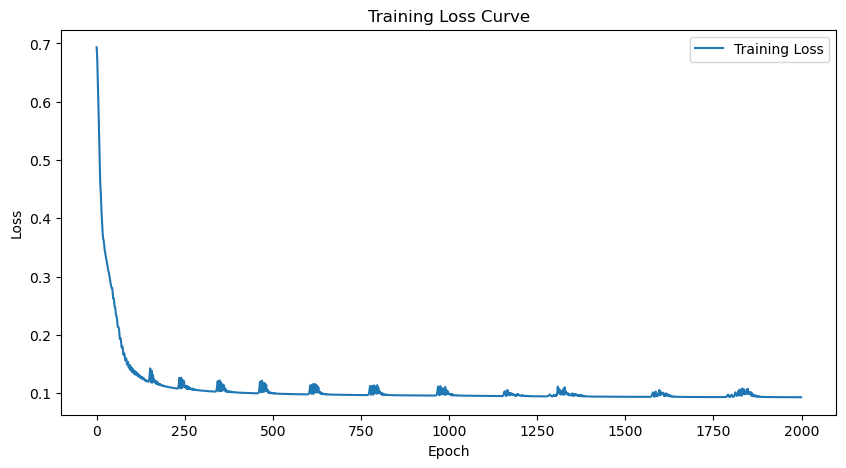

Final Model Accuracy: 77.11%
Final Model F1-score: 0.7704


In [9]:
input_dim = X_train.shape[1]
hidden_dim = 256 
print(f"Training MLP model with input_dim={input_dim} and hidden_dim={hidden_dim}")

custom_mlp, losses, best_accuracy, best_f1 = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [10]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_0_layer.pth'.


In [11]:
print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

Final Model Accuracy: 77.11%


/tmp/ipykernel_1716370/3740627605.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()


                  precision    recall  f1-score   support

    infringement       0.79      0.76      0.77       194
non_infringement       0.76      0.78      0.77       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380

